#**2.1. Реализация tanh**

In [8]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.t = (np.exp(X) - np.exp(-X))/(np.exp(X) + np.exp(-X))
        return self.t

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (1 - self.t ** 2) * dLdy

    def step(self, learning_rate):
        pass

#**2.2. Сравнение аугментаций**

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import torch
import sys
from IPython.display import clear_output

%matplotlib inline

class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

class Linear:
    def __init__(self, input_size, output_size):
        self.W = np.random.randn(input_size, output_size)*0.01
        self.b = np.zeros(output_size)

    def forward(self, X):
        self.X = X
        return X.dot(self.W)+self.b

    def backward(self, dLdy):
        self.dLdW = self.X.T.dot(dLdy)
        self.dLdb = dLdy.sum(0)
        self.dLdx = dLdy.dot(self.W.T)
        return self.dLdx

    def step(self, learning_rate):
        self.W = self.W - learning_rate * self.dLdW
        self.b = self.b - learning_rate * self.dLdb

class NLLLoss:
    def __init__(self):
        pass

    def forward(self, X, y):
        self.p = np.exp(X)
        self.p /= self.p.sum(1, keepdims=True)
        self.y = np.zeros((X.shape[0], X.shape[1]))
        self.y[np.arange(X.shape[0]), y] = 1
        return -(np.log(self.p)*self.y).sum(1).mean(0)

    def backward(self):
        return (self.p - self.y) / self.y.shape[0]

class NeuralNetwork:
    def __init__(self, modules):
        self.modules = modules

    def forward(self, X):
        y = X
        for i in range(len(self.modules)):
            y = self.modules[i].forward(y)
        return y

    def backward(self, dLdy):
        for i in range(len(self.modules))[::-1]:
            dLdy = self.modules[i].backward(dLdy)

    def step(self, learning_rate):
        for i in range(len(self.modules)):
            self.modules[i].step(learning_rate)

In [2]:
def train(network, epochs, learning_rate, train_loader, test_loader, verbose=True, loss=None):
    loss_func = loss or NLLLoss()
    train_loss_epochs, test_loss_epochs = [], []
    train_accuracy_epochs, test_accuracy_epochs = [], []

    try:
        for epoch in range(epochs):
            losses, accuracies = [], []
            for X, y in train_loader:
                X_np = X.view(X.shape[0], -1).numpy()
                y_np = y.numpy()
                prediction = network.forward(X_np)
                loss_batch = loss_func.forward(prediction, y_np)
                losses.append(loss_batch)
                dLdx = loss_func.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1) == y_np).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))

            losses, accuracies = [], []
            for X, y in test_loader:
                X_np = X.view(X.shape[0], -1).numpy()
                y_np = y.numpy()
                prediction = network.forward(X_np)
                loss_batch = loss_func.forward(prediction, y_np)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1) == y_np).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))

            if verbose:
                sys.stdout.write(
                    f"\rEpoch {epoch}... (Train/Test) NLL: {train_loss_epochs[-1]:.3f}/{test_loss_epochs[-1]:.3f}\t"
                    f"Accuracy: {train_accuracy_epochs[-1]:.3f}/{test_accuracy_epochs[-1]:.3f}"
                )
    except KeyboardInterrupt:
        pass

    return train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs

In [3]:
base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

rotation_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

shift_transform = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

noise_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 0.1*torch.randn_like(x)),
    transforms.Normalize((0.1307,), (0.3081,))
])

all_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 0.1*torch.randn_like(x)),
    transforms.Normalize((0.1307,), (0.3081,))
])

transforms_dict = {
    "base": base_transform,
    "rotation": rotation_transform,
    "shift": shift_transform,
    "noise": noise_transform,
    "all": all_transform
}


In [4]:
results = {}

for name, tr in transforms_dict.items():
    print(f"\nTraining with {name} augmentation...")

    train_dataset = MNIST('.', train=True, download=True, transform=tr)
    test_dataset = MNIST('.', train=False, transform=base_transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    net = NeuralNetwork([
        Linear(784, 100), ReLU(),
        Linear(100, 100), ReLU(),
        Linear(100, 10)
    ])

    train_loss, test_loss, train_acc, test_acc = train(
        net, epochs=5, learning_rate=0.01,
        train_loader=train_loader, test_loader=test_loader, verbose=True
    )

    results[name] = {
        "train_loss": train_loss,
        "test_loss": test_loss,
        "train_acc": train_acc,
        "test_acc": test_acc
    }



Training with base augmentation...


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 505kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.06MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.72MB/s]


Epoch 4... (Train/Test) NLL: 0.188/0.171	Accuracy: 0.946/0.950
Training with rotation augmentation...
Epoch 4... (Train/Test) NLL: 0.223/0.164	Accuracy: 0.934/0.953
Training with shift augmentation...
Epoch 4... (Train/Test) NLL: 0.312/0.183	Accuracy: 0.909/0.946
Training with noise augmentation...
Epoch 4... (Train/Test) NLL: 0.194/0.166	Accuracy: 0.944/0.952
Training with all augmentation...
Epoch 4... (Train/Test) NLL: 0.383/0.185	Accuracy: 0.885/0.948

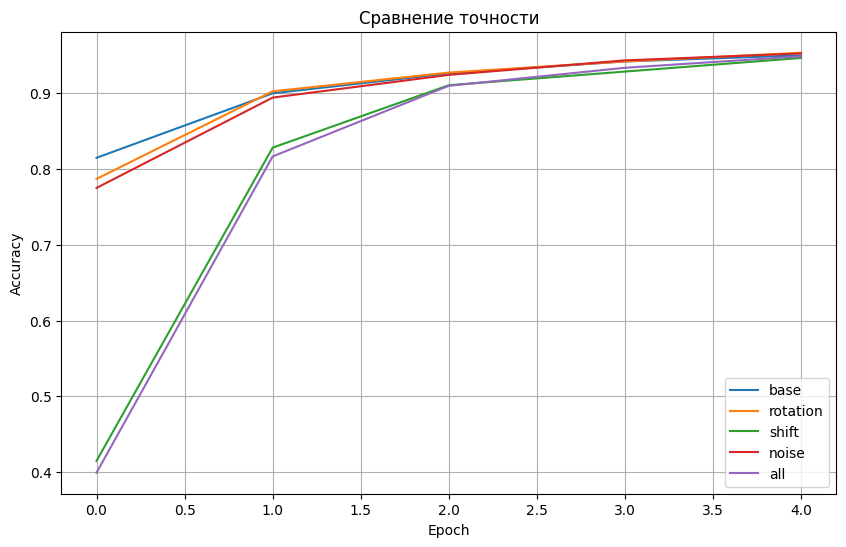

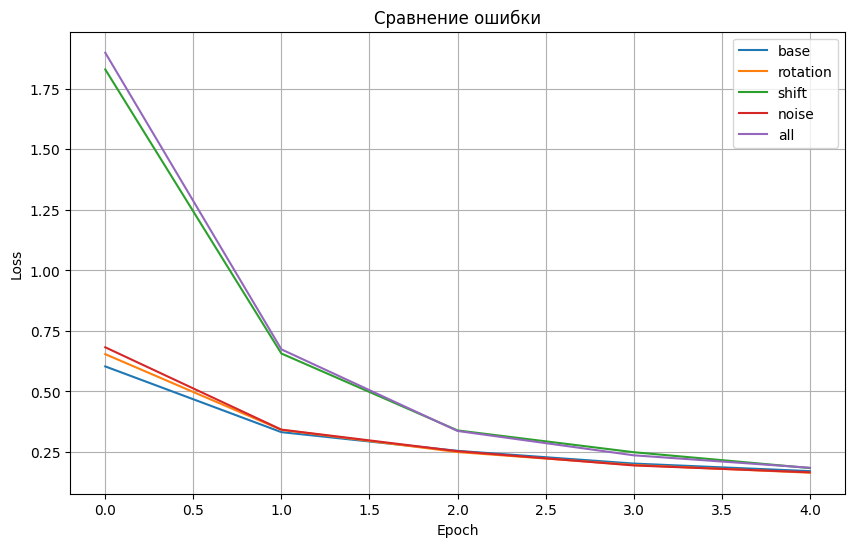

In [6]:
plt.figure(figsize=(10,6))
for name, res in results.items():
    plt.plot(res["test_acc"], label=name)
plt.title("Сравнение точности")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,6))
for name, res in results.items():
    plt.plot(res["test_loss"], label=name)
plt.title("Сравнение ошибки")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()
